Some libraries

In [58]:
import pandas as pd
import numpy as np

We are going to change the labels of the dataset to numbers. After this transformation, the labels in df["Label"] will be numerical (e.g., 0 for air_conditioner, 1 for car_horn, etc.), which is ideal for use in metrics like the confusion matrix.

In [59]:
# Load the 10 folds into a list of DataFrames
datasets = [pd.read_csv(f"datasets/sound_features_fold{i}.csv") for i in range(1, 11)]

# Define the mapping of labels to numbers
labels_dict = {
    "air_conditioner": 0,
    "car_horn": 1,
    "children_playing": 2,
    "dog_bark": 3,
    "drilling": 4,
    "engine_idling": 5,
    "gun_shot": 6,
    "jackhammer": 7,
    "siren": 8,
    "street_music": 9
}
# Replace string labels with numeric labels in each fold DataFrame
for df in datasets:
    df["Label"] = df["Label"].replace(labels_dict)

# Check the updated labels in the first fold
datasets[0].head()

/var/folders/sm/nnvpnt0s5wx5_hw325ljf2gr0000gn/T/ipykernel_35050/2401856071.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Label"] = df["Label"].replace(labels_dict)


,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,...,spectral_centroid,spectral_bandwidth,spectral_contrast,spectral_rolloff,spectral_flatness,rms,zero_crossing_rate,tempo,tempogram,Label
0,-374.44590,97.047250,9.259301,-17.928537,1.152152,-8.538063,-15.637719,-8.188658,-11.003868,1.985415,...,960.279319,1313.641864,22.421554,1763.516865,0.003240,0.079418,0.050405,[66.96428571],0.040491,3
1,-333.74377,133.216250,15.807837,-33.060143,-1.289476,-17.097427,-30.018026,-22.263353,-18.194607,4.316967,...,865.872849,1143.308567,23.852010,1420.634921,0.001789,0.087223,0.053943,[110.29411765],0.059969,3
2,-382.80362,68.959465,4.313661,-2.062933,3.721442,-5.117520,-8.518147,-1.823458,-4.410032,4.914453,...,1132.635828,1453.488132,21.033922,2213.789683,0.009837,0.052242,0.059059,[52.08333333],0.031151,3
3,-96.21553,87.579865,-52.939266,-5.229744,-16.976635,3.661066,-4.204170,10.106073,3.249916,10.754143,...,1801.149302,1495.233043,21.253521,3214.285714,0.039912,0.118702,0.158978,[170.45454545],0.115612,3
4,-217.80743,124.950710,21.462078,11.288554,-10.218013,0.942786,-1.060578,7.175950,0.728432,1.115492,...,1163.692856,1572.547755,20.424197,2396.515377,0.015071,0.070206,0.071091,[133.92857143],0.025050,6


Now lets check if there is some obejct values and replace them

In [60]:
for df in datasets:
    object_columns = df.select_dtypes(include=['object']).columns
    print(object_columns)

Index(['tempo'], dtype='object')
Index(['tempo'], dtype='object')
Index(['tempo'], dtype='object')
Index(['tempo'], dtype='object')
Index(['tempo'], dtype='object')
Index(['tempo'], dtype='object')
Index(['tempo'], dtype='object')
Index(['tempo'], dtype='object')
Index(['tempo'], dtype='object')
Index(['tempo'], dtype='object')


In [61]:
# Example: Check what type of obejct 'tempo' is
print(datasets[0]['tempo'].head())

0     [66.96428571]
1    [110.29411765]
2     [52.08333333]
3    [170.45454545]
4    [133.92857143]
Name: tempo, dtype: object


In [62]:
import ast  # For safely evaluating the string representation of lists

for df in datasets:
    # Convert the string representation of lists to actual lists
    df['tempo'] = df['tempo'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    # Now, extract the first value from the list (if it’s a list)
    df['tempo'] = df['tempo'].apply(lambda x: x[0] if isinstance(x, list) else x)

    # Convert the 'tempo' column to numeric
    df['tempo'] = pd.to_numeric(df['tempo'], errors='coerce')

    # Check for NaN values
    print(df['tempo'].isna().sum())  # Count of NaN values

    # Handle NaN values (optional)
    df['tempo'].fillna(df['tempo'].mean(), inplace=True)  # Fill NaNs with the mean
    # Alternatively, you could drop rows with NaNs: df.dropna(subset=['tempo'], inplace=True)
datasets[0].head()

0
0
0
0
0
0
0
0
0
0


/var/folders/sm/nnvpnt0s5wx5_hw325ljf2gr0000gn/T/ipykernel_35050/3544635880.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['tempo'].fillna(df['tempo'].mean(), inplace=True)  # Fill NaNs with the mean


,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,...,spectral_centroid,spectral_bandwidth,spectral_contrast,spectral_rolloff,spectral_flatness,rms,zero_crossing_rate,tempo,tempogram,Label
0,-374.44590,97.047250,9.259301,-17.928537,1.152152,-8.538063,-15.637719,-8.188658,-11.003868,1.985415,...,960.279319,1313.641864,22.421554,1763.516865,0.003240,0.079418,0.050405,66.964286,0.040491,3
1,-333.74377,133.216250,15.807837,-33.060143,-1.289476,-17.097427,-30.018026,-22.263353,-18.194607,4.316967,...,865.872849,1143.308567,23.852010,1420.634921,0.001789,0.087223,0.053943,110.294118,0.059969,3
2,-382.80362,68.959465,4.313661,-2.062933,3.721442,-5.117520,-8.518147,-1.823458,-4.410032,4.914453,...,1132.635828,1453.488132,21.033922,2213.789683,0.009837,0.052242,0.059059,52.083333,0.031151,3
3,-96.21553,87.579865,-52.939266,-5.229744,-16.976635,3.661066,-4.204170,10.106073,3.249916,10.754143,...,1801.149302,1495.233043,21.253521,3214.285714,0.039912,0.118702,0.158978,170.454545,0.115612,3
4,-217.80743,124.950710,21.462078,11.288554,-10.218013,0.942786,-1.060578,7.175950,0.728432,1.115492,...,1163.692856,1572.547755,20.424197,2396.515377,0.015071,0.070206,0.071091,133.928571,0.025050,6


In [63]:
for df in datasets:
    object_columns = df.select_dtypes(include=['object']).columns
    print(object_columns)

Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')


Before training our model, it's important to understand the distribution of the classes in the dataset. A class imbalance can lead to poor performance, especially when the model is biased toward the majority class. We will visualize the class distribution using a bar plot to see if any classes are underrepresented.

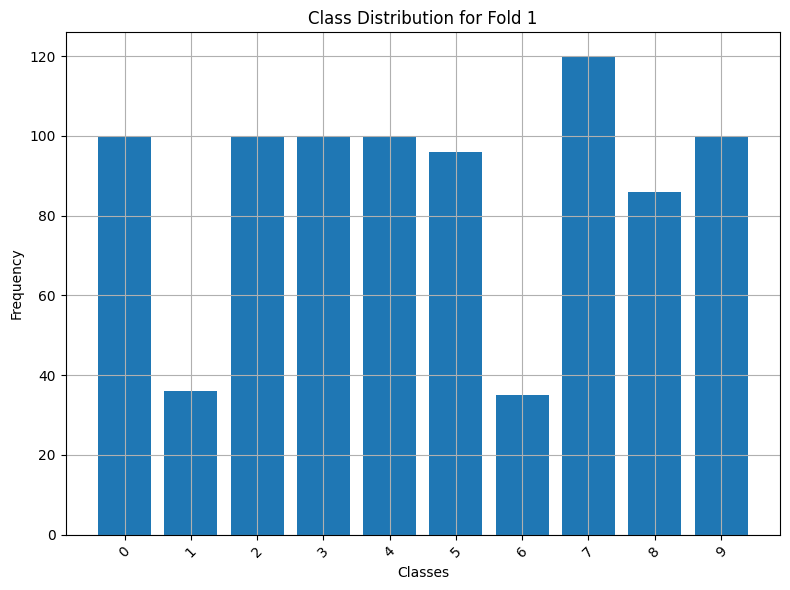

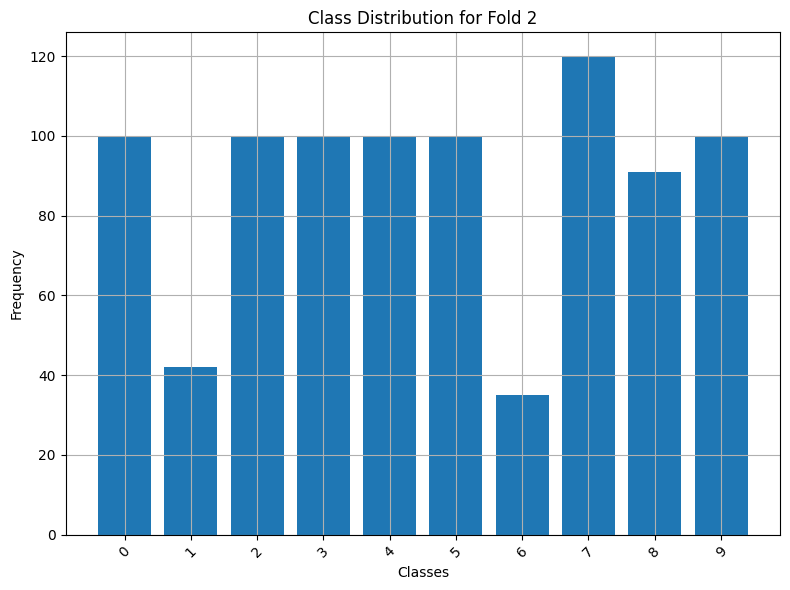

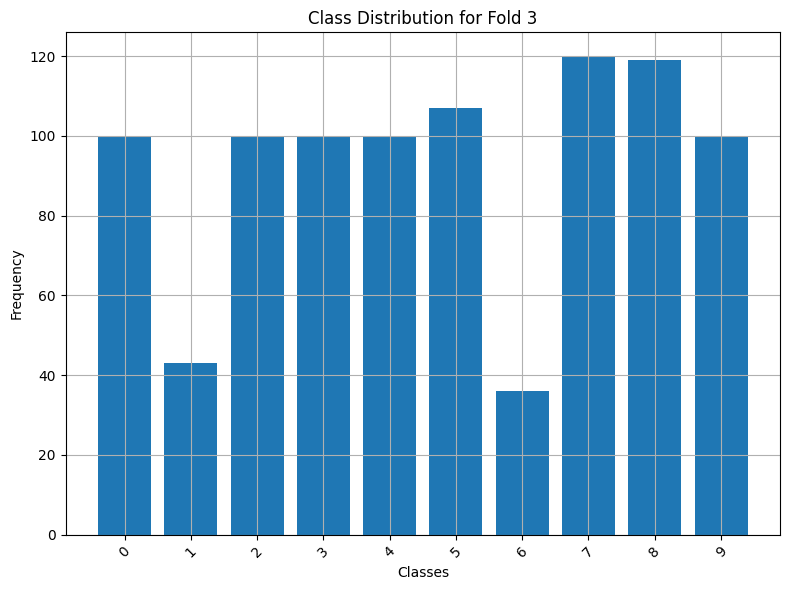

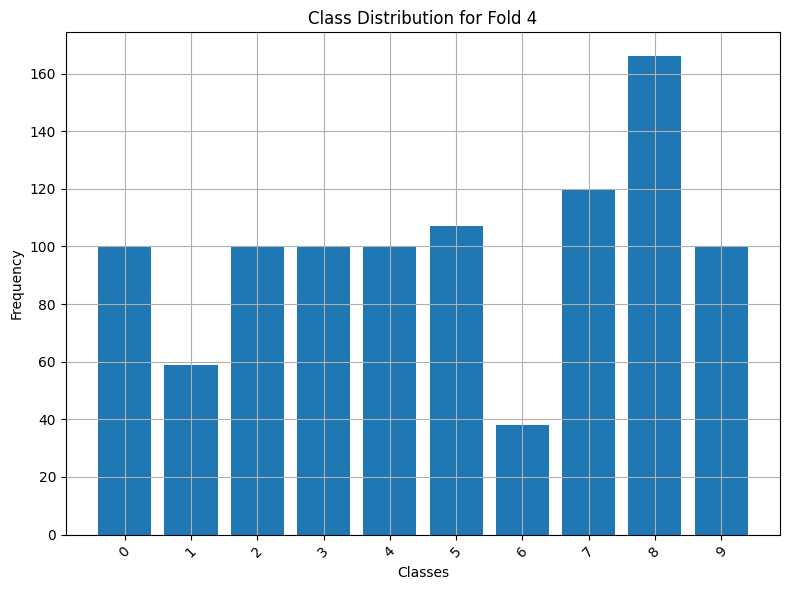

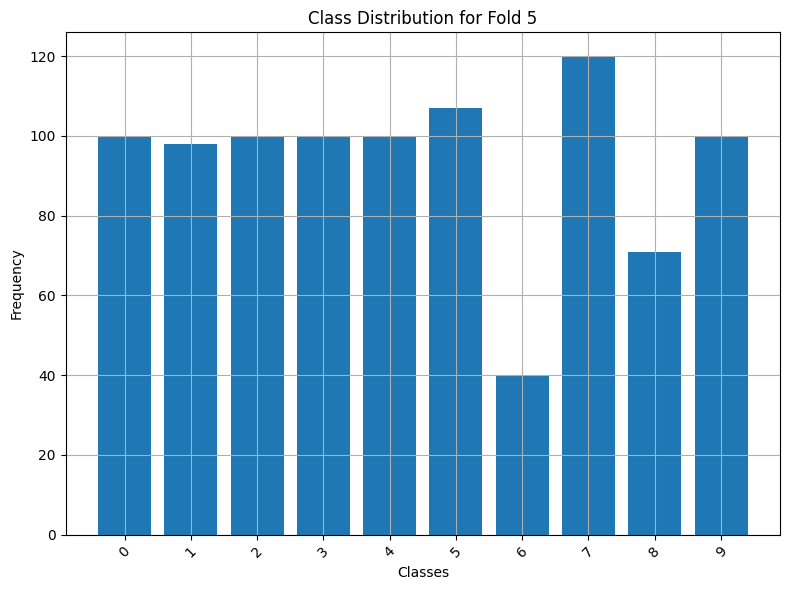

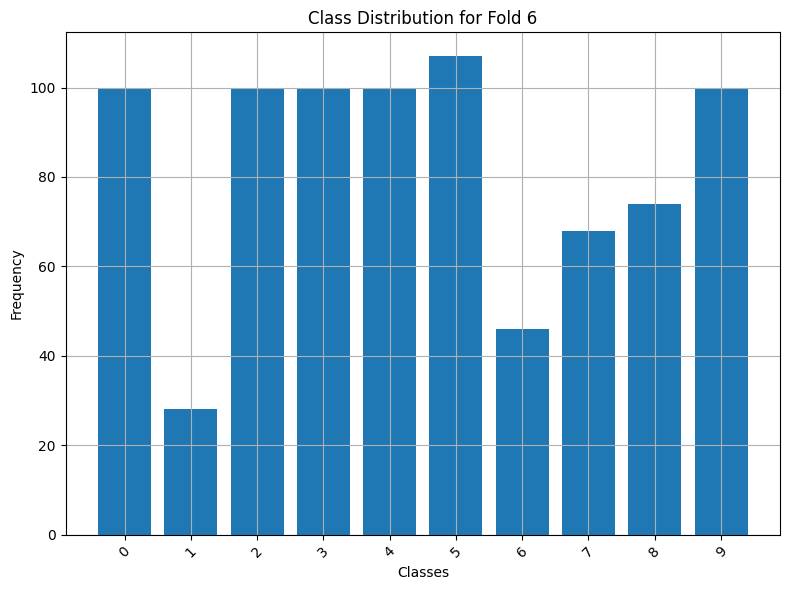

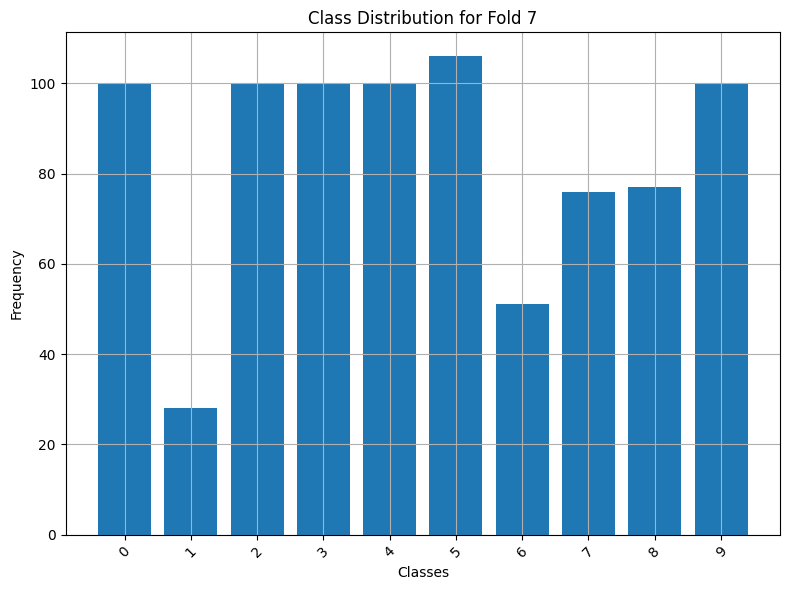

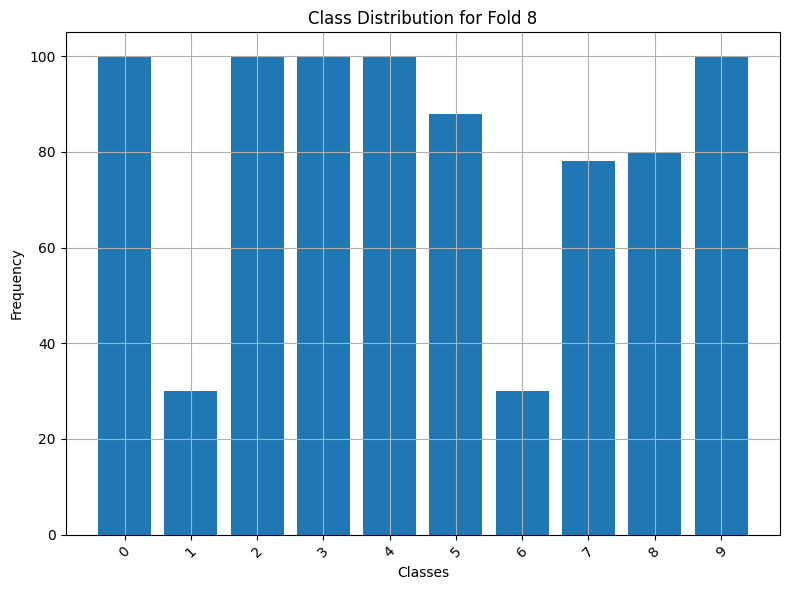

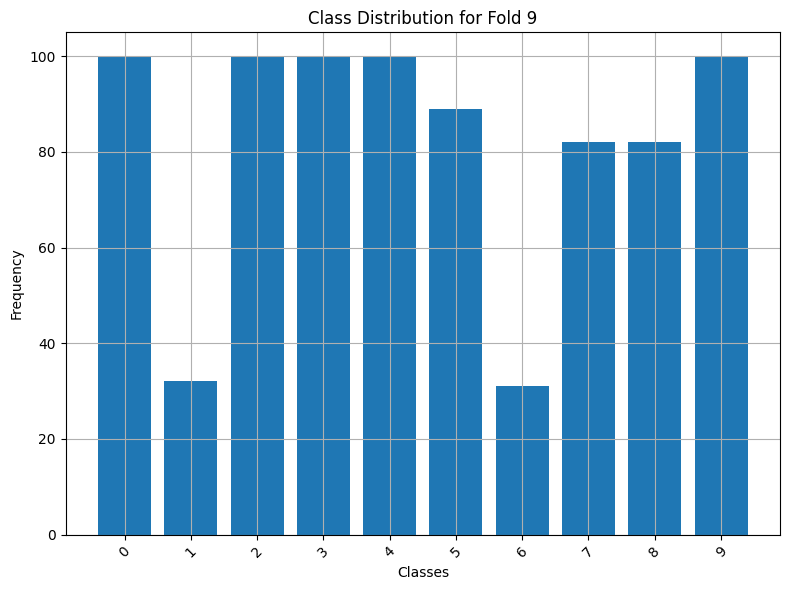

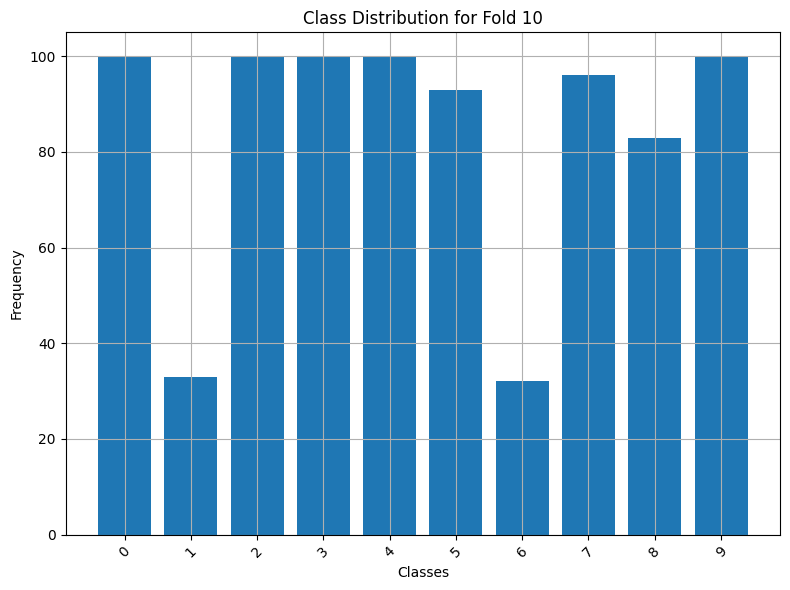

In [64]:
import matplotlib.pyplot as plt

# Define a function to plot the class distribution for each dataset
def plot_class_distribution(df, fold_number):
    plt.figure(figsize=(8, 6))
    # Plot the distribution of the 'Label' column (class labels)
    plt.hist(df['Label'], bins=np.arange(0, 11) - 0.5, rwidth=0.8)
    plt.xticks(np.arange(10), rotation=45)
    plt.title(f"Class Distribution for Fold {fold_number}")
    plt.xlabel("Classes")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()  # To ensure the labels fit into the plot properly
    plt.show()

# Plot the class distribution for each fold
for i, df in enumerate(datasets):
    plot_class_distribution(df, i+1)


The class distribution is imbalanced in the datasets, we will apply **SMOTE (Synthetic Minority Over-sampling Technique)** to balance the classes. SMOTE will generate synthetic samples for the underrepresented classes.

We will apply SMOTE individually to each dataset (fold) in the train data(because we dont want to use synthetic samples when testing data for it to test on real examples), ensuring that each fold has a balanced class distribution.


In [65]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import random

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


In [66]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20)

In [67]:

def create_mlp_model(input_dim, num_classes):
    model = Sequential([
        Dense(512, activation='relu', input_dim=input_dim),
        Dropout(0.5),  # Dropout for regularization
        Dense(512, activation='relu'),
        Dropout(0.5),  # Dropout for regularization
        Dense(512,activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # Output layer for multi-class classification
    ])
    return model

In [68]:
def generate_folds_plots(test_fold,history,conf_matrix):
    # Generate per-fold plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"Fold {test_fold} Performance", fontsize=16)

    # Plot accuracy
    axes[0].plot(history.history['accuracy'], label="Train", color="blue")
    axes[0].plot(history.history['val_accuracy'], label="Validation", color="orange")
    axes[0].set_title("Model Accuracy")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend()

    # Plot loss
    axes[1].plot(history.history['loss'], label="Train", color="blue")
    axes[1].plot(history.history['val_loss'], label="Validation", color="orange")
    axes[1].set_title("Model Loss")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].legend()

    # Plot confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[2])
    axes[2].set_title("Confusion Matrix")
    axes[2].set_xlabel("Predicted Label")
    axes[2].set_ylabel("True Label")

    # Adjust layout and save/show the plot
    plt.tight_layout()
    plt.show()
    

Processing Fold 1...


/Users/dimiborges252/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold 1: Accuracy = 0.6140


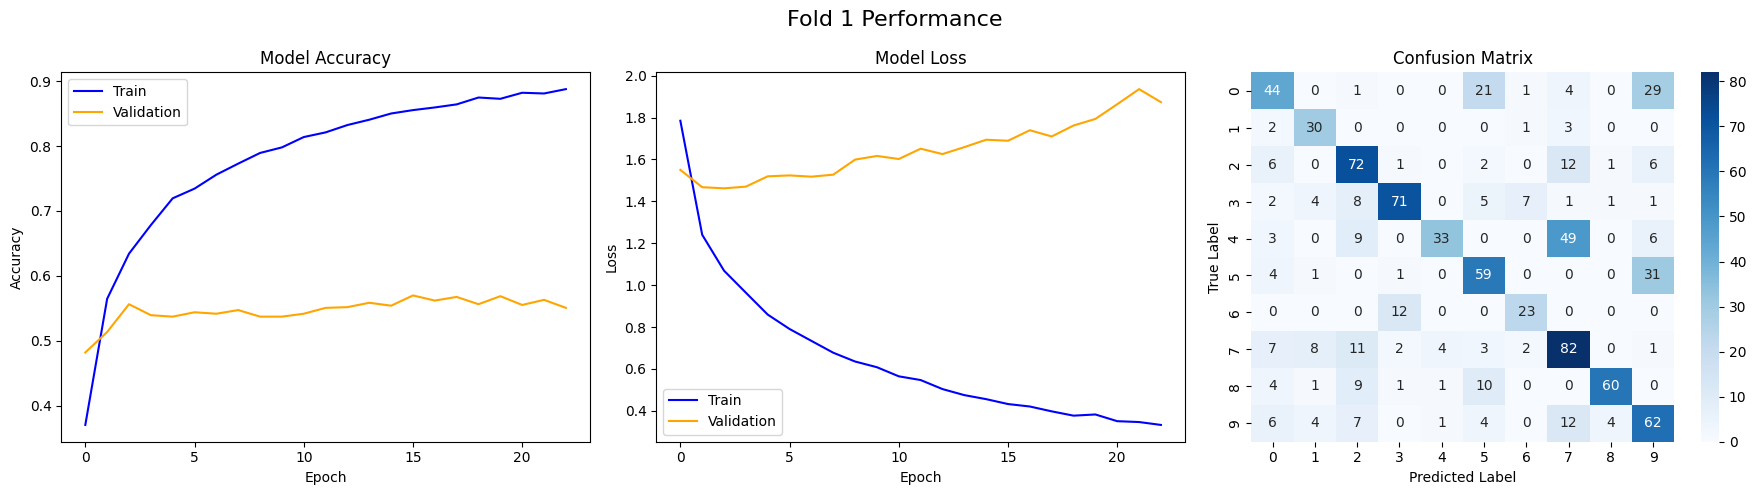

Processing Fold 2...


/Users/dimiborges252/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold 2: Accuracy = 0.5315


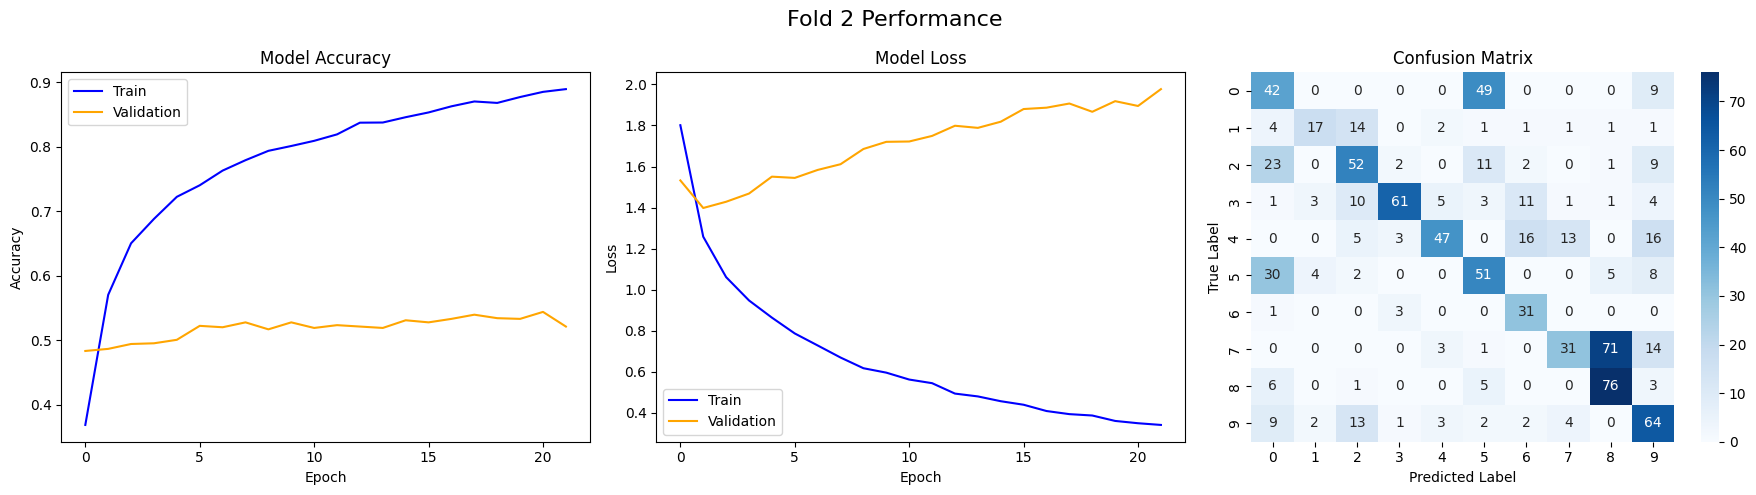

Processing Fold 3...


/Users/dimiborges252/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold 3: Accuracy = 0.4778


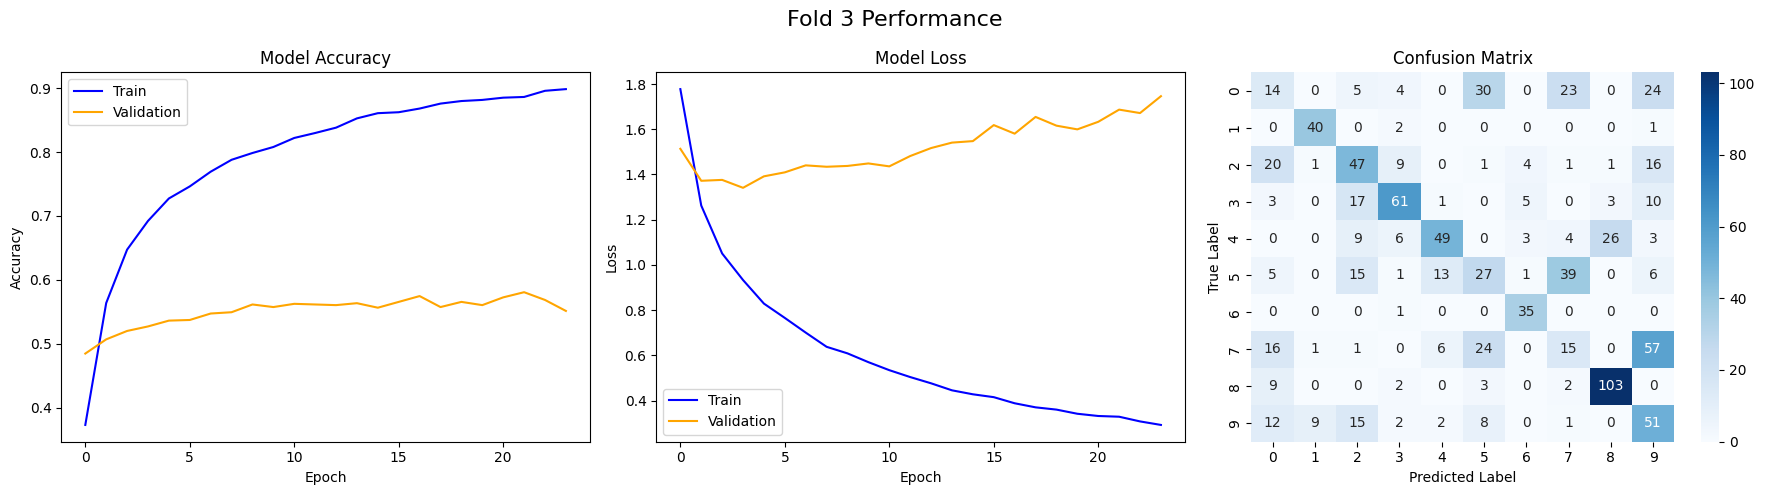

Processing Fold 4...


/Users/dimiborges252/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 4: Accuracy = 0.5646


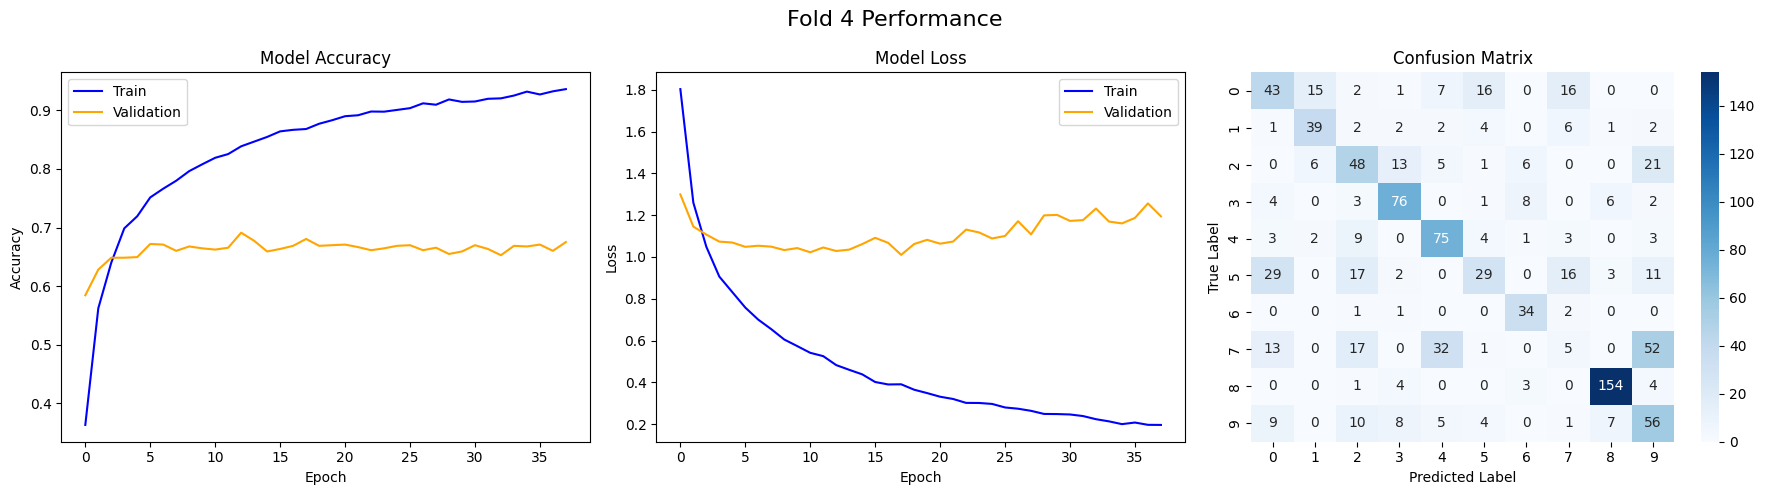

Processing Fold 5...


/Users/dimiborges252/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold 5: Accuracy = 0.6271


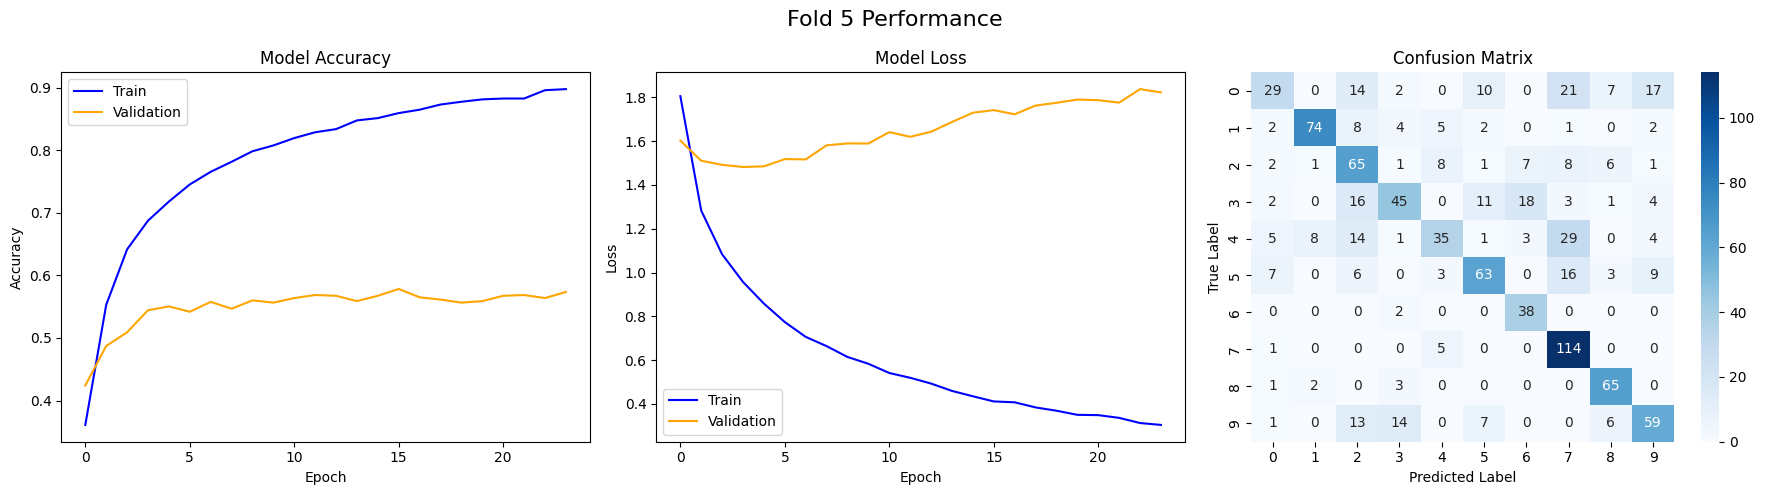

Processing Fold 6...


/Users/dimiborges252/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold 6: Accuracy = 0.5735


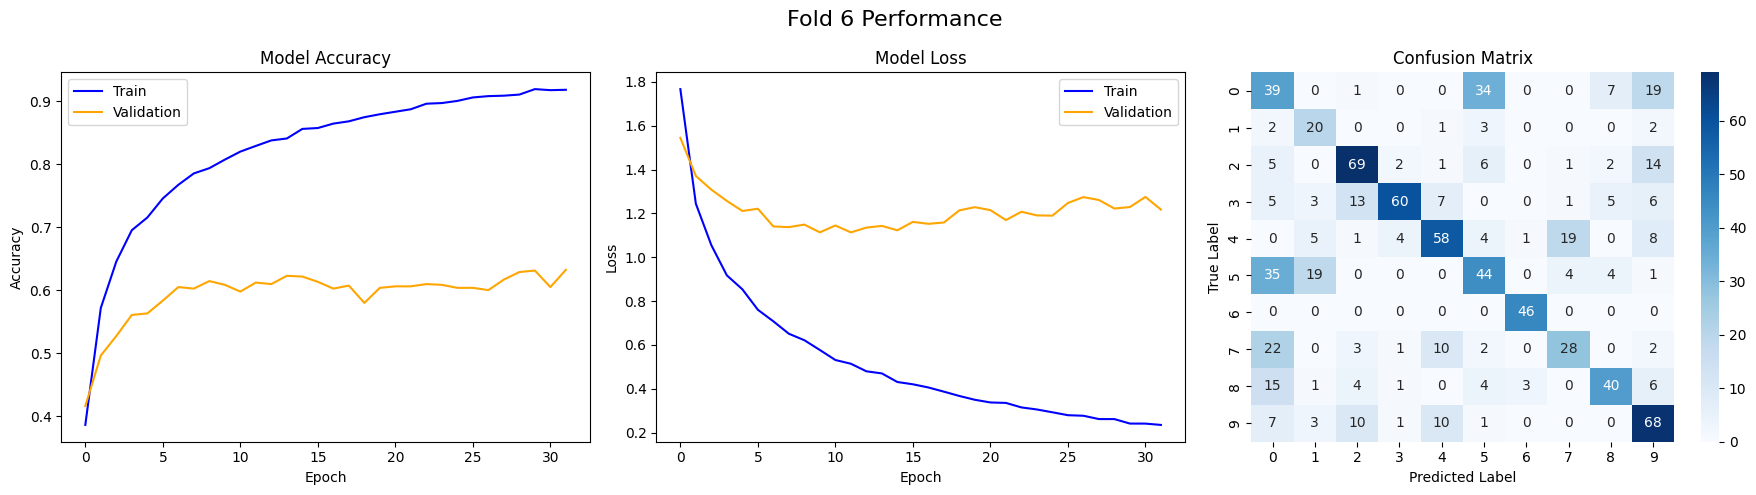

Processing Fold 7...


/Users/dimiborges252/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold 7: Accuracy = 0.5513


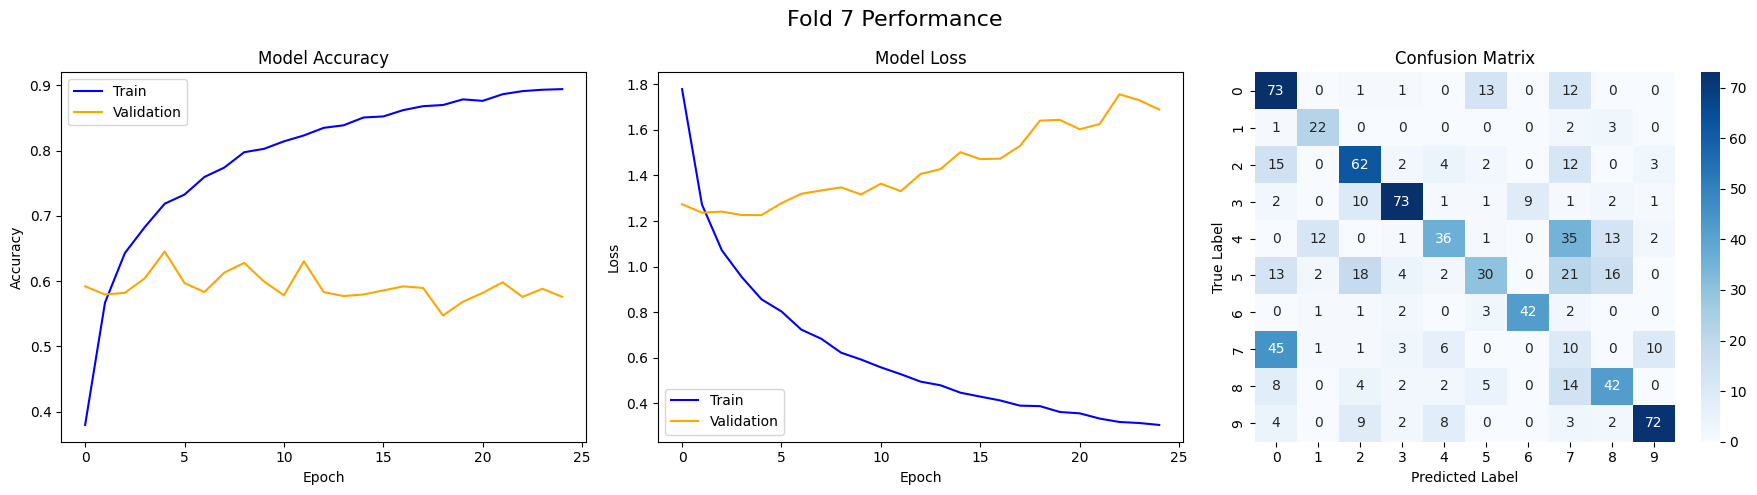

Processing Fold 8...


/Users/dimiborges252/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 8: Accuracy = 0.6290


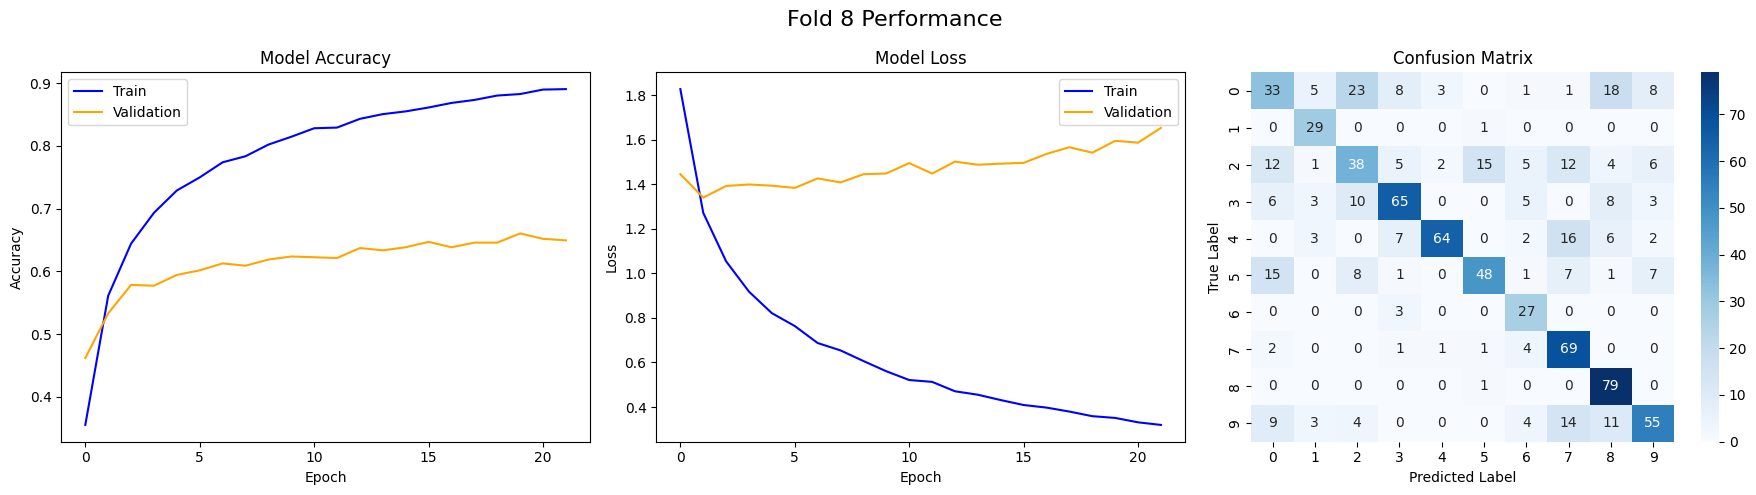

Processing Fold 9...


/Users/dimiborges252/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold 9: Accuracy = 0.6152


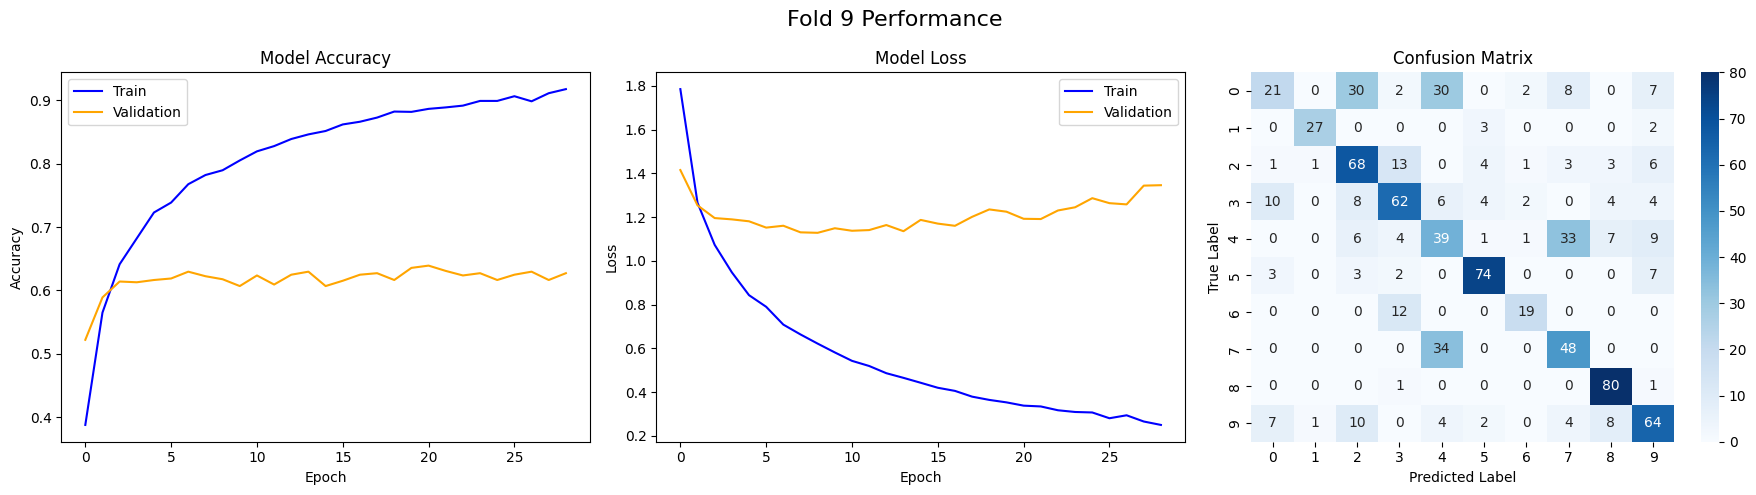

Processing Fold 10...


/Users/dimiborges252/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold 10: Accuracy = 0.5938


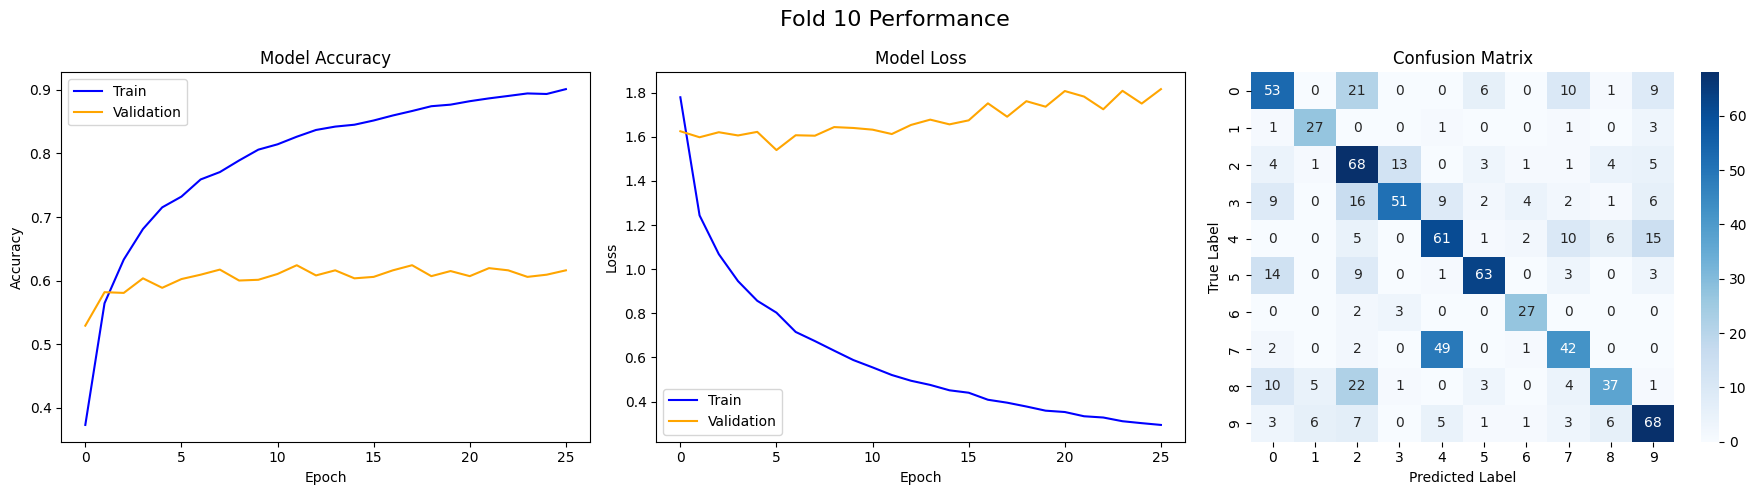

Final Average Accuracy for MLP: 0.5778 ± 0.0459
Standard Deviation for MLP Accuracy 0.0459


In [69]:
learning_rate = 0.0005
batch_size = 128
epochs = 50
# Initialize lists for storing results
accuracies = []
confusion_matrices = []

# Perform 10-fold cross-validation
for test_fold in range(1, 11):
    print(f"Processing Fold {test_fold}...")
    
    # Test data
    test_data = datasets[test_fold - 1]
    X_test = test_data.drop(columns=['Label']).values
    y_test = test_data['Label'].values

    # Validation fold
    val_fold = (test_fold % 10) + 1  # Fold after the test fold (cyclic)
    val_data = datasets[val_fold - 1]
    X_val = val_data.drop(columns=['Label']).values
    y_val = val_data['Label'].values

    # Training data (remaining 8 folds)
    train_data = pd.concat([datasets[i] for i in range(10) if i not in [test_fold - 1, val_fold - 1]])
    X_train = train_data.drop(columns=['Label']).values
    y_train = train_data['Label'].values

    # Apply SMOTE to the training data
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Standardize features
    scaler = StandardScaler()
    X_train_smote = scaler.fit_transform(X_train_smote)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Create and compile the MLP model
    input_dim = X_train_smote.shape[1]
    num_classes = len(np.unique(y_train))
    model = create_mlp_model(input_dim, num_classes)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(
        X_train_smote, y_train_smote,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, lr_scheduler],
        verbose=0
    )

    # Evaluate on the test set
    y_pred = np.argmax(model.predict(X_test), axis=1)
    acc = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Store results
    accuracies.append(acc)
    confusion_matrices.append(conf_matrix)

    print(f"Fold {test_fold}: Accuracy = {acc:.4f}")
    
    generate_folds_plots(test_fold,history,conf_matrix)

# Compute final metrics
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
final_confusion_matrix = np.sum(confusion_matrices, axis=0)

# Display results
print(f"Final Average Accuracy for MLP: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Standard Deviation for MLP Accuracy {std_accuracy:.4f}")


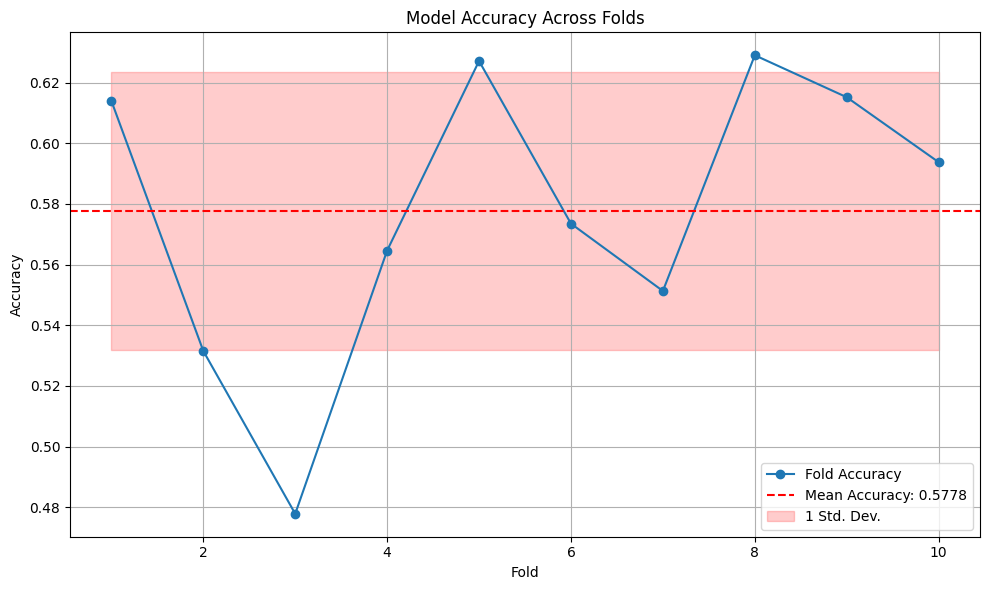

In [70]:
# Plot accuracy for each fold
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), accuracies, marker='o', label='Fold Accuracy')
plt.axhline(np.mean(accuracies), color='r', linestyle='--', label=f'Mean Accuracy: {np.mean(accuracies):.4f}')
plt.fill_between(range(1, 11),
                 np.mean(accuracies) - np.std(accuracies),
                 np.mean(accuracies) + np.std(accuracies),
                 color='r', alpha=0.2, label='1 Std. Dev.')
plt.title("Model Accuracy Across Folds")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


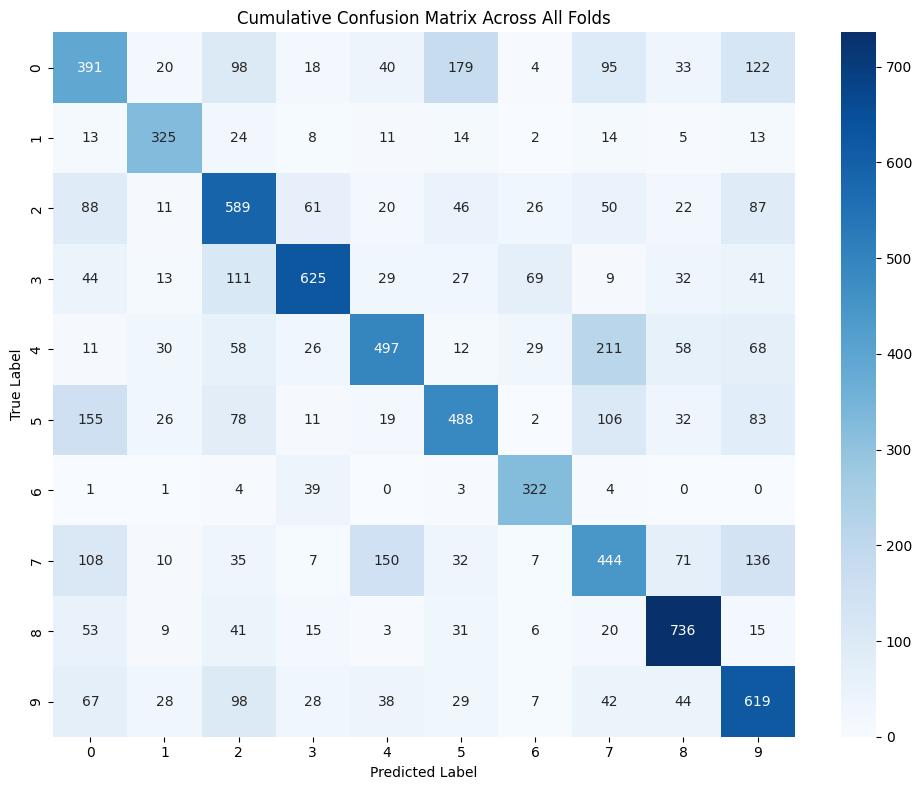

In [71]:
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(final_confusion_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
plt.title("Cumulative Confusion Matrix Across All Folds")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [72]:
from tensorflow.keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D

In [73]:
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))  # 10 classes

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


Processing Fold 1...
Epoch 1/50


/Users/dimiborges252/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2386 - loss: 2.1293 - val_accuracy: 0.4324 - val_loss: 1.6211 - learning_rate: 0.0010
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4935 - loss: 1.4531 - val_accuracy: 0.4932 - val_loss: 1.4638 - learning_rate: 0.0010
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5755 - loss: 1.2392 - val_accuracy: 0.5180 - val_loss: 1.4153 - learning_rate: 0.0010
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6237 - loss: 1.1127 - val_accuracy: 0.5327 - val_loss: 1.3810 - learning_rate: 0.0010
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6538 - loss: 1.0308 - val_accuracy: 0.5450 - val_loss: 1.3758 - learning_rate: 0.0010
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6779 - loss: 0.9630 - val_accuracy: 0.5282 - val_loss: 1.3737 - learning_rate: 0.0010
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6999 - loss: 0.8998 - val_accuracy: 0.5327 - va

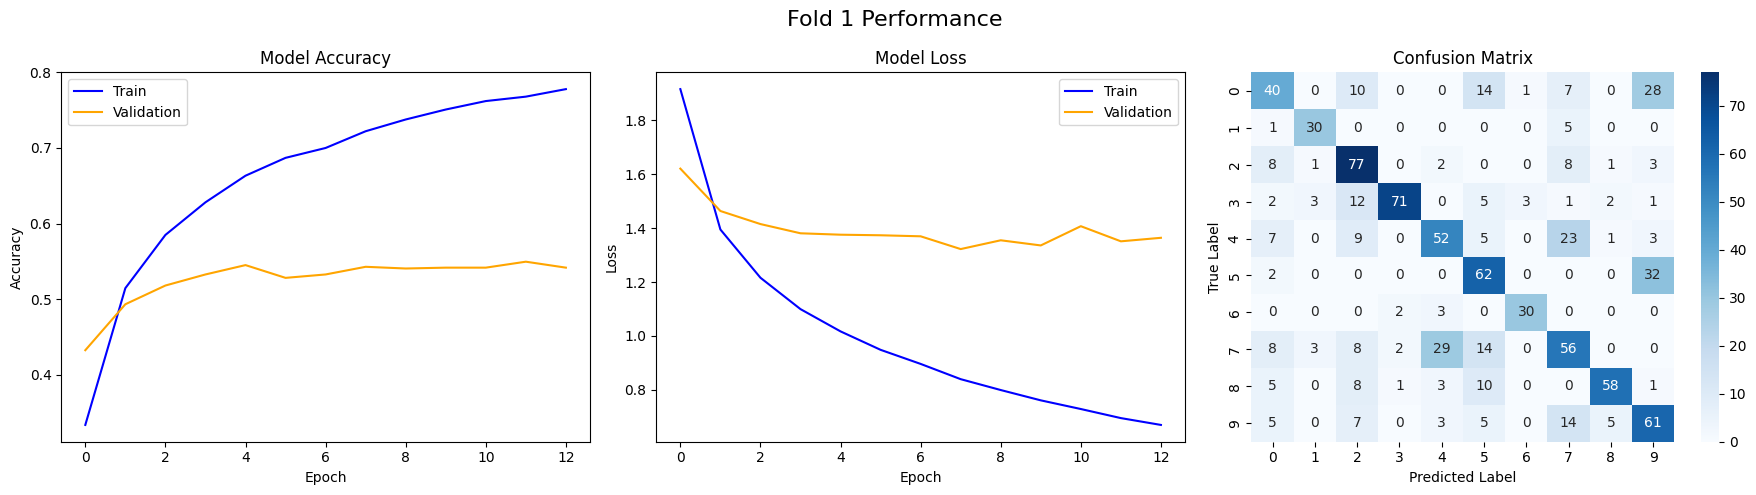

Fold 1: Test accuracy: 0.6151
Processing Fold 2...
Epoch 1/50


/Users/dimiborges252/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2417 - loss: 2.1206 - val_accuracy: 0.3838 - val_loss: 1.6974 - learning_rate: 0.0010
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4968 - loss: 1.4635 - val_accuracy: 0.4292 - val_loss: 1.5098 - learning_rate: 0.0010
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5878 - loss: 1.2336 - val_accuracy: 0.4681 - val_loss: 1.4745 - learning_rate: 0.0010
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6252 - loss: 1.1063 - val_accuracy: 0.4714 - val_loss: 1.4664 - learning_rate: 0.0010
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6653 - loss: 1.0194 - val_accuracy: 0.4865 - val_loss: 1.4470 - learning_rate: 0.0010
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7009 - loss: 0.9280 - val_accuracy: 0.4778 - val_loss: 1.4522 - learning_rate: 0.0010
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7057 - loss: 0.8747 - val_accuracy: 0.4854 - va

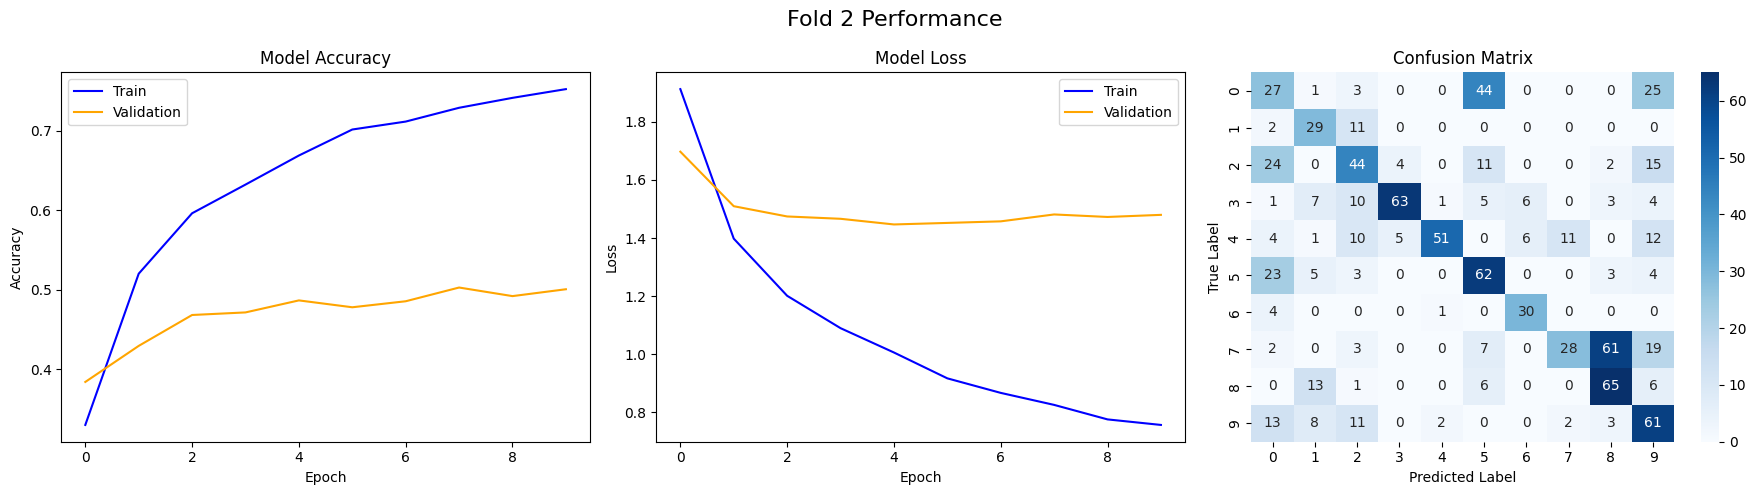

Fold 2: Test accuracy: 0.5180
Processing Fold 3...
Epoch 1/50


/Users/dimiborges252/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2398 - loss: 2.1147 - val_accuracy: 0.4212 - val_loss: 1.6890 - learning_rate: 0.0010
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5028 - loss: 1.4604 - val_accuracy: 0.4636 - val_loss: 1.5142 - learning_rate: 0.0010
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5779 - loss: 1.2168 - val_accuracy: 0.4899 - val_loss: 1.4039 - learning_rate: 0.0010
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6386 - loss: 1.0940 - val_accuracy: 0.5091 - val_loss: 1.3223 - learning_rate: 0.0010
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6605 - loss: 1.0045 - val_accuracy: 0.5364 - val_loss: 1.2919 - learning_rate: 0.0010
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6981 - loss: 0.9225 - val_accuracy: 0.5545 - val_loss: 1.2261 - learning_rate: 0.0010
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7128 - loss: 0.8686 - val_accuracy: 0.5414 - va

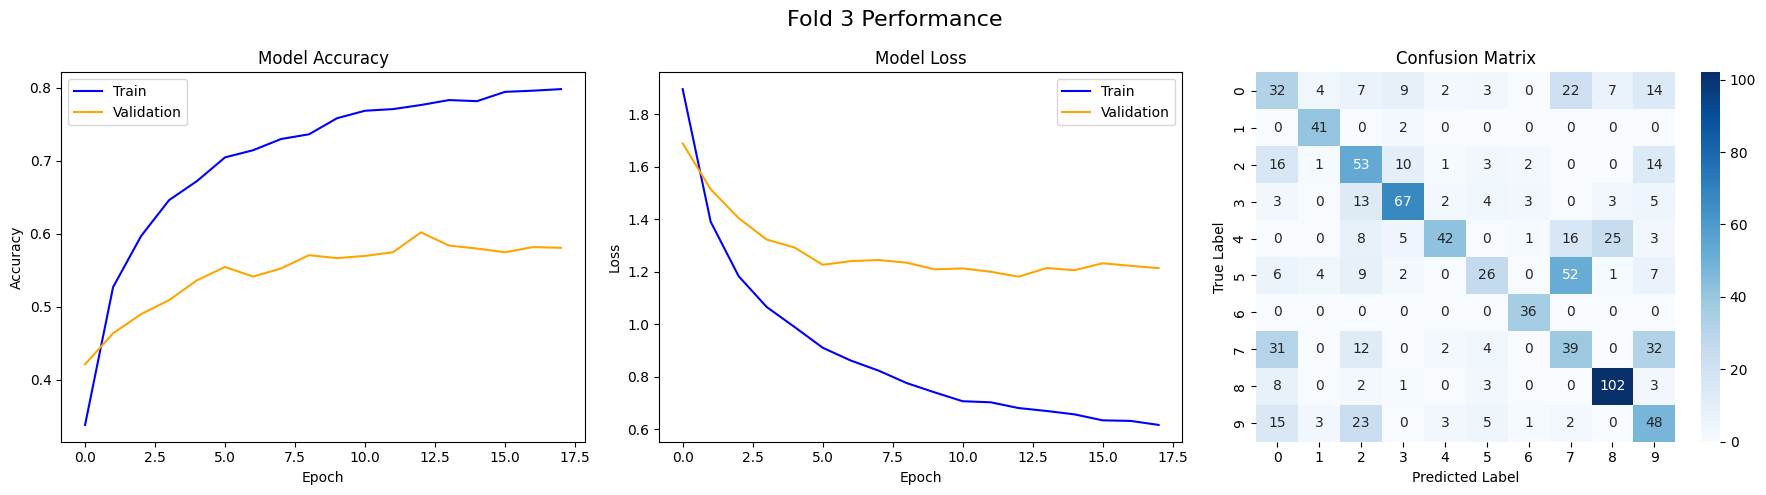

Fold 3: Test accuracy: 0.5254
Processing Fold 4...
Epoch 1/50


/Users/dimiborges252/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2174 - loss: 2.1242 - val_accuracy: 0.5310 - val_loss: 1.4993 - learning_rate: 0.0010
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4885 - loss: 1.4855 - val_accuracy: 0.5620 - val_loss: 1.3321 - learning_rate: 0.0010
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5784 - loss: 1.2600 - val_accuracy: 0.6111 - val_loss: 1.2216 - learning_rate: 0.0010
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6161 - loss: 1.1332 - val_accuracy: 0.6143 - val_loss: 1.1683 - learning_rate: 0.0010
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6658 - loss: 1.0295 - val_accuracy: 0.6239 - val_loss: 1.1213 - learning_rate: 0.0010
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6856 - loss: 0.9542 - val_accuracy: 0.6378 - val_loss: 1.1008 - learning_rate: 0.0010
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7063 - loss: 0.8969 - val_accuracy: 0.6613 - va

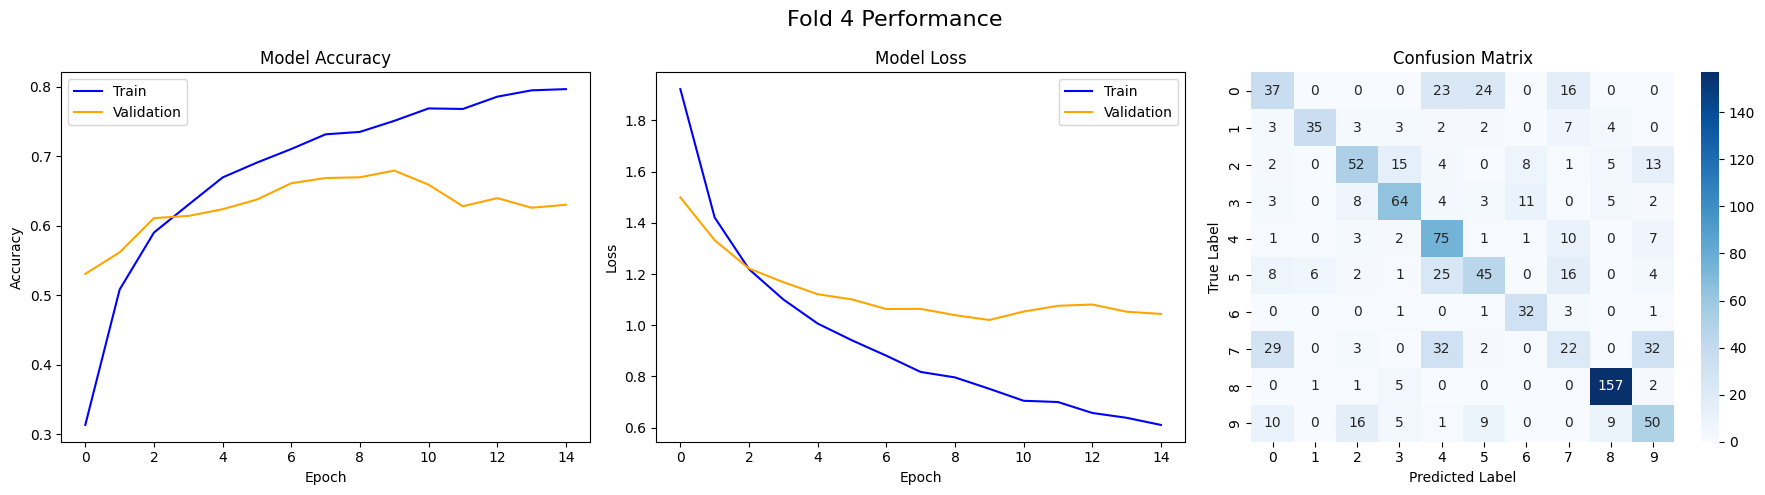

Fold 4: Test accuracy: 0.5747
Processing Fold 5...
Epoch 1/50


/Users/dimiborges252/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2441 - loss: 2.1037 - val_accuracy: 0.3597 - val_loss: 1.6921 - learning_rate: 0.0010
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4923 - loss: 1.4762 - val_accuracy: 0.4338 - val_loss: 1.5216 - learning_rate: 0.0010
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5645 - loss: 1.2644 - val_accuracy: 0.4909 - val_loss: 1.4321 - learning_rate: 0.0010
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6227 - loss: 1.1278 - val_accuracy: 0.5200 - val_loss: 1.3954 - learning_rate: 0.0010
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6606 - loss: 1.0311 - val_accuracy: 0.5079 - val_loss: 1.4260 - learning_rate: 0.0010
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6803 - loss: 0.9617 - val_accuracy: 0.5200 - val_loss: 1.4220 - learning_rate: 0.0010
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7040 - loss: 0.8910 - val_accuracy: 0.5225 - va

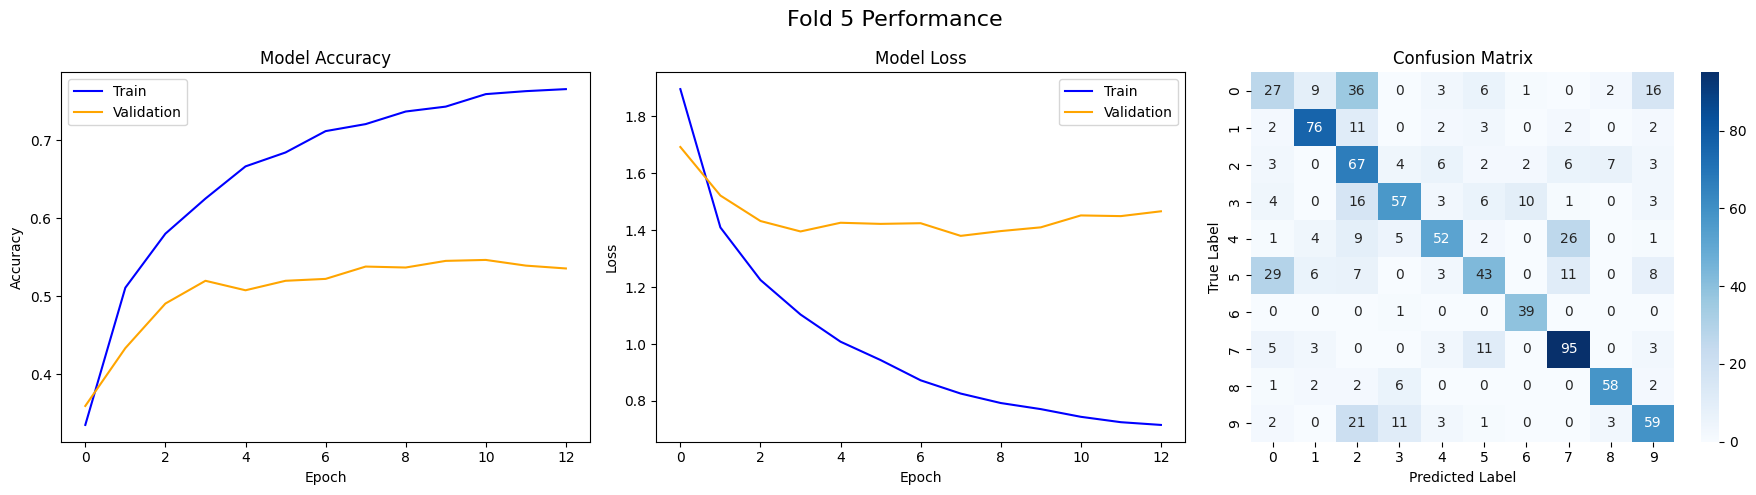

Fold 5: Test accuracy: 0.6122
Processing Fold 6...
Epoch 1/50


/Users/dimiborges252/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2543 - loss: 2.0973 - val_accuracy: 0.4356 - val_loss: 1.6481 - learning_rate: 0.0010
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4984 - loss: 1.4422 - val_accuracy: 0.5048 - val_loss: 1.4221 - learning_rate: 0.0010
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5893 - loss: 1.2187 - val_accuracy: 0.5286 - val_loss: 1.3315 - learning_rate: 0.0010
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6301 - loss: 1.0955 - val_accuracy: 0.5692 - val_loss: 1.2473 - learning_rate: 0.0010
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6618 - loss: 0.9930 - val_accuracy: 0.5585 - val_loss: 1.2309 - learning_rate: 0.0010
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6997 - loss: 0.9207 - val_accuracy: 0.5656 - val_loss: 1.1875 - learning_rate: 0.0010
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7144 - loss: 0.8487 - val_accuracy: 0.5800 - va

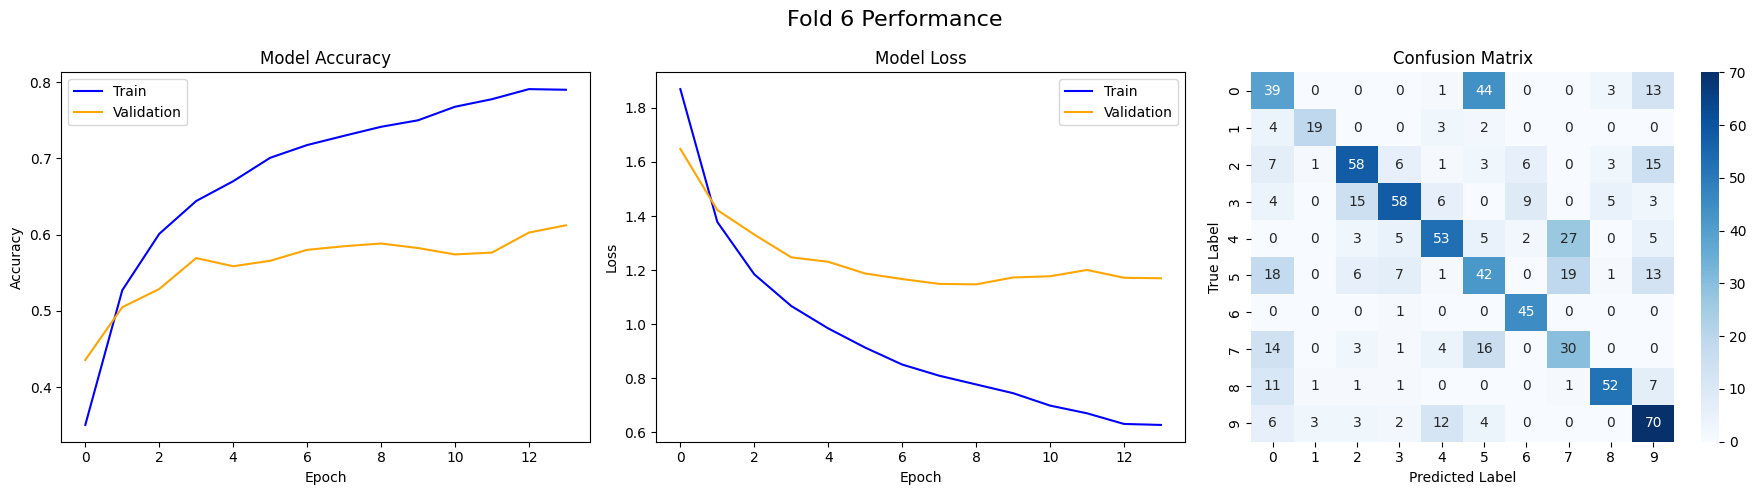

Fold 6: Test accuracy: 0.5662
Processing Fold 7...
Epoch 1/50


/Users/dimiborges252/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2345 - loss: 2.1040 - val_accuracy: 0.5298 - val_loss: 1.4217 - learning_rate: 0.0010
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4789 - loss: 1.4988 - val_accuracy: 0.5757 - val_loss: 1.2636 - learning_rate: 0.0010
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5530 - loss: 1.3016 - val_accuracy: 0.5757 - val_loss: 1.2217 - learning_rate: 0.0010
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6015 - loss: 1.1567 - val_accuracy: 0.5968 - val_loss: 1.2009 - learning_rate: 0.0010
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6484 - loss: 1.0610 - val_accuracy: 0.6067 - val_loss: 1.1843 - learning_rate: 0.0010
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6785 - loss: 0.9739 - val_accuracy: 0.6241 - val_loss: 1.1527 - learning_rate: 0.0010
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7020 - loss: 0.8920 - val_accuracy: 0.5868 - va

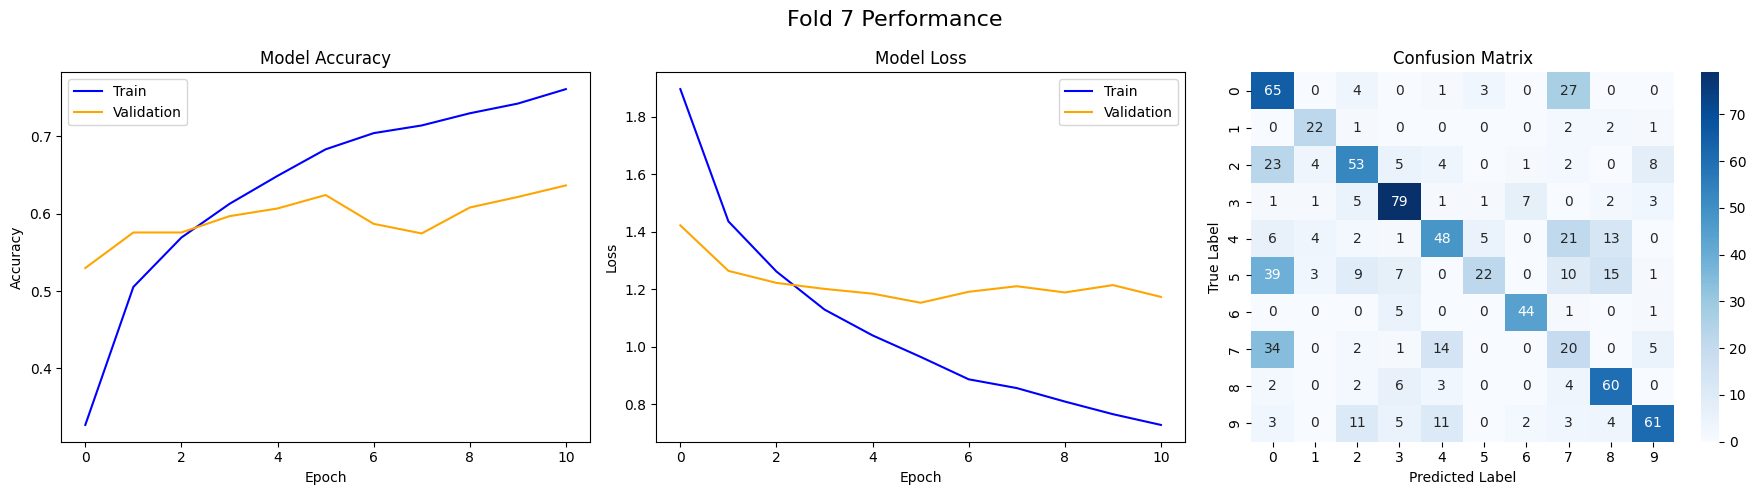

Fold 7: Test accuracy: 0.5656
Processing Fold 8...
Epoch 1/50


/Users/dimiborges252/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2275 - loss: 2.1287 - val_accuracy: 0.3885 - val_loss: 1.6063 - learning_rate: 0.0010
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4914 - loss: 1.4817 - val_accuracy: 0.4755 - val_loss: 1.3932 - learning_rate: 0.0010
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5664 - loss: 1.2519 - val_accuracy: 0.5686 - val_loss: 1.2805 - learning_rate: 0.0010
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6306 - loss: 1.1138 - val_accuracy: 0.5662 - val_loss: 1.2393 - learning_rate: 0.0010
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6628 - loss: 1.0082 - val_accuracy: 0.6054 - val_loss: 1.1709 - learning_rate: 0.0010
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6890 - loss: 0.9394 - val_accuracy: 0.6115 - val_loss: 1.1614 - learning_rate: 0.0010
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7171 - loss: 0.8657 - val_accuracy: 0.6176 - va

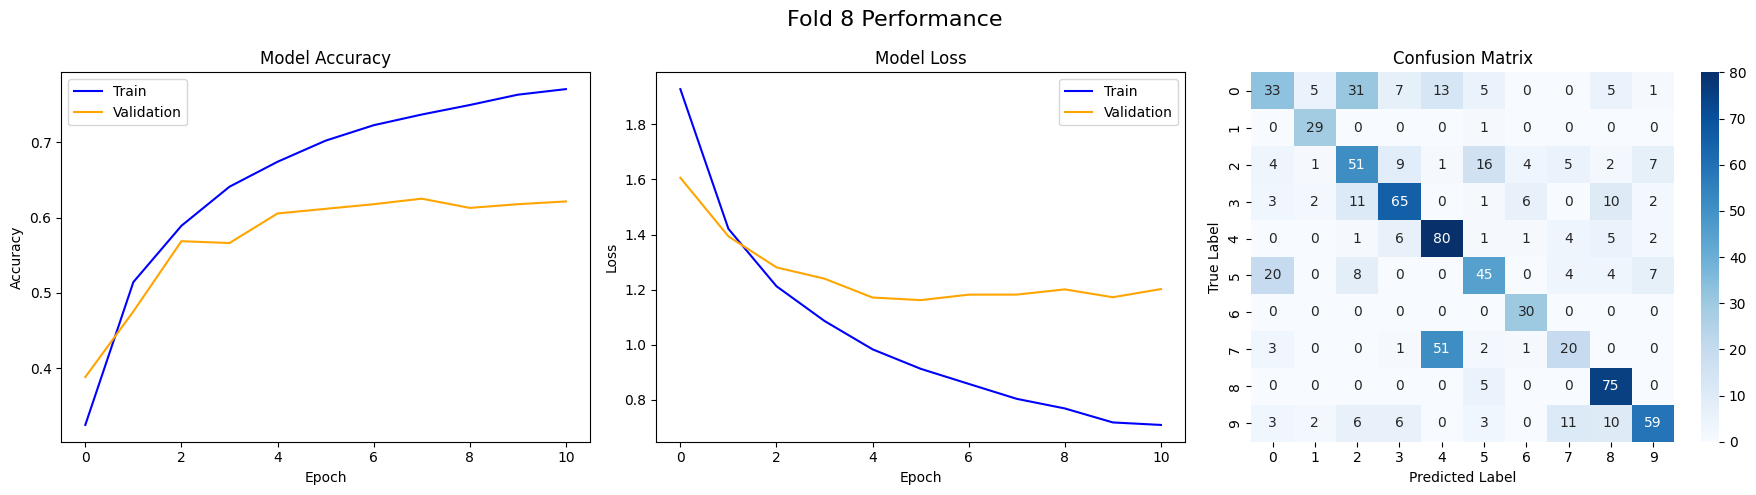

Fold 8: Test accuracy: 0.6042
Processing Fold 9...
Epoch 1/50


/Users/dimiborges252/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2528 - loss: 2.1017 - val_accuracy: 0.5364 - val_loss: 1.4888 - learning_rate: 0.0010
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4818 - loss: 1.4831 - val_accuracy: 0.5806 - val_loss: 1.3409 - learning_rate: 0.0010
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5548 - loss: 1.2860 - val_accuracy: 0.5842 - val_loss: 1.2661 - learning_rate: 0.0010
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6106 - loss: 1.1402 - val_accuracy: 0.6010 - val_loss: 1.1991 - learning_rate: 0.0010
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6340 - loss: 1.0712 - val_accuracy: 0.6129 - val_loss: 1.1529 - learning_rate: 0.0010
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6661 - loss: 0.9877 - val_accuracy: 0.6260 - val_loss: 1.1198 - learning_rate: 0.0010
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6910 - loss: 0.9342 - val_accuracy: 0.6225 - va

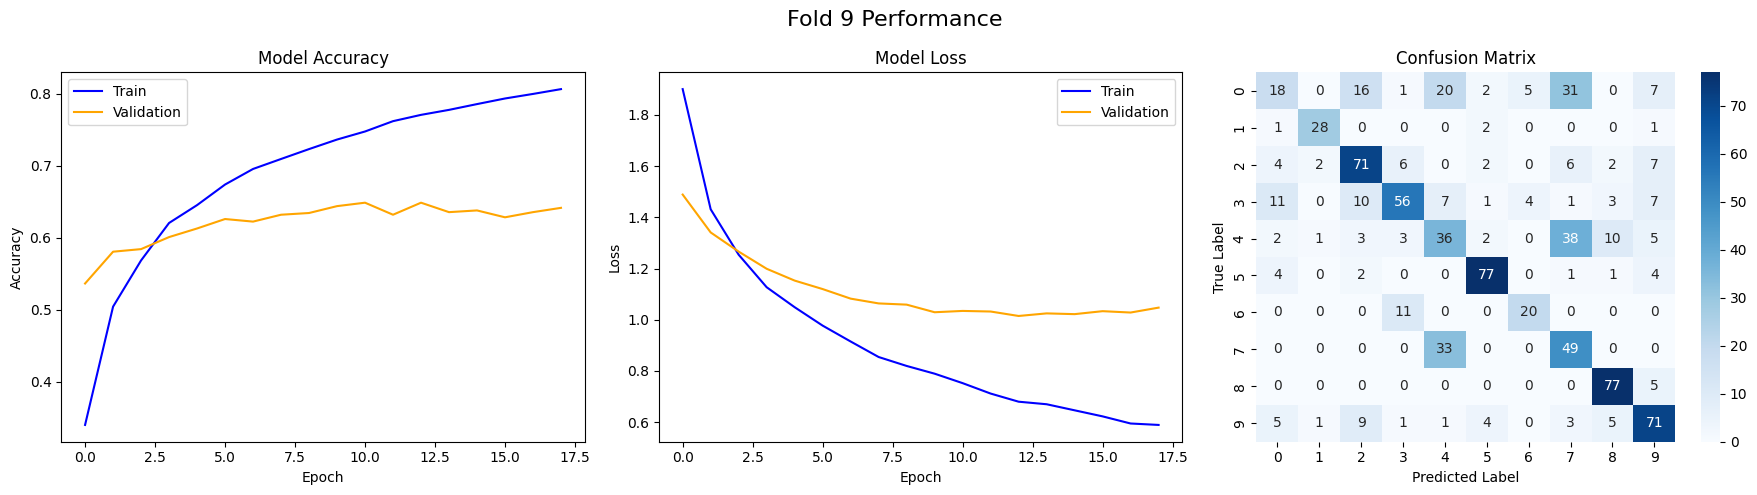

Fold 9: Test accuracy: 0.6164
Processing Fold 10...
Epoch 1/50


/Users/dimiborges252/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2378 - loss: 2.1186 - val_accuracy: 0.4513 - val_loss: 1.7343 - learning_rate: 0.0010
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4796 - loss: 1.5032 - val_accuracy: 0.5017 - val_loss: 1.5608 - learning_rate: 0.0010
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5539 - loss: 1.3055 - val_accuracy: 0.5601 - val_loss: 1.4567 - learning_rate: 0.0010
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6137 - loss: 1.1554 - val_accuracy: 0.5830 - val_loss: 1.4340 - learning_rate: 0.0010
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6498 - loss: 1.0523 - val_accuracy: 0.5865 - val_loss: 1.4168 - learning_rate: 0.0010
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6795 - loss: 0.9984 - val_accuracy: 0.5934 - val_loss: 1.4200 - learning_rate: 0.0010
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6965 - loss: 0.9132 - val_accuracy: 0.5945 - va

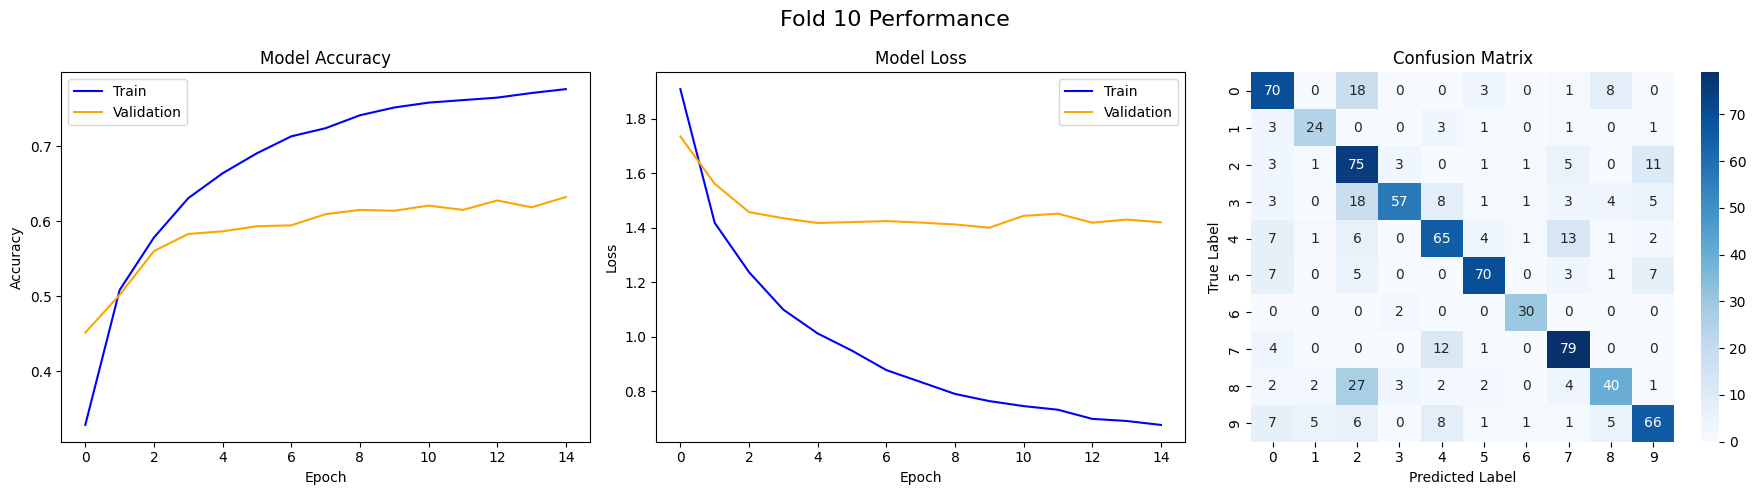

Fold 10: Test accuracy: 0.6882
Final Average Accuracy for MLP: 0.5886 ± 0.0473
Standard Deviation for MLP Accuracy 0.0473


In [74]:
all_y_true = []
all_y_pred = []
accuracies = []

for test_fold in range(1, 11):
    print(f"Processing Fold {test_fold}...")

    # Dividir os dados entre treino, validação e teste
    test_data = datasets[test_fold - 1]
    X_test = test_data.drop(columns=['Label']).values
    y_test = test_data['Label'].values

    val_fold = (test_fold % 10) + 1  # Fold para validação
    val_data = datasets[val_fold - 1]
    X_val = val_data.drop(columns=['Label']).values
    y_val = val_data['Label'].values

    train_data = pd.concat([datasets[i] for i in range(10) if i not in [test_fold - 1, val_fold - 1]])
    X_train = train_data.drop(columns=['Label']).values
    y_train = train_data['Label'].values

    # Aplicar SMOTE aos dados de treinamento
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Normalizar os dados
    scaler = StandardScaler()
    X_train_smote = scaler.fit_transform(X_train_smote)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Redimensionar os dados para (n_samples, altura=1, largura=n_features, canais=1)
    X_train_smote = X_train_smote.reshape(X_train_smote.shape[0], 1, X_train_smote.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], 1)

    # Criar e treinar o modelo
    input_shape = (1, X_train_smote.shape[2], 1)  # Alteração aqui para garantir a forma correta
    model = create_cnn_model(input_shape)

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)

    history = model.fit(
        x=X_train_smote,
        y=y_train_smote,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=128,
        verbose=1,
        callbacks=[early_stopping, reduce_lr]
    )

    # Fazer previsões
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Acumular valores reais e previstos
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred_classes)

    # Matriz de confusão para o fold atual
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Plotar os gráficos lado a lado
    generate_folds_plots(test_fold,history,conf_matrix)

    # Exibir a acurácia final do fold
    accuracy = accuracy_score(y_test, y_pred_classes)
    accuracies.append(accuracy)
    print(f"Fold {test_fold}: Test accuracy: {accuracy:.4f}")

# Compute final metrics
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
# Display results
print(f"Final Average Accuracy for MLP: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Standard Deviation for MLP Accuracy {std_accuracy:.4f}")

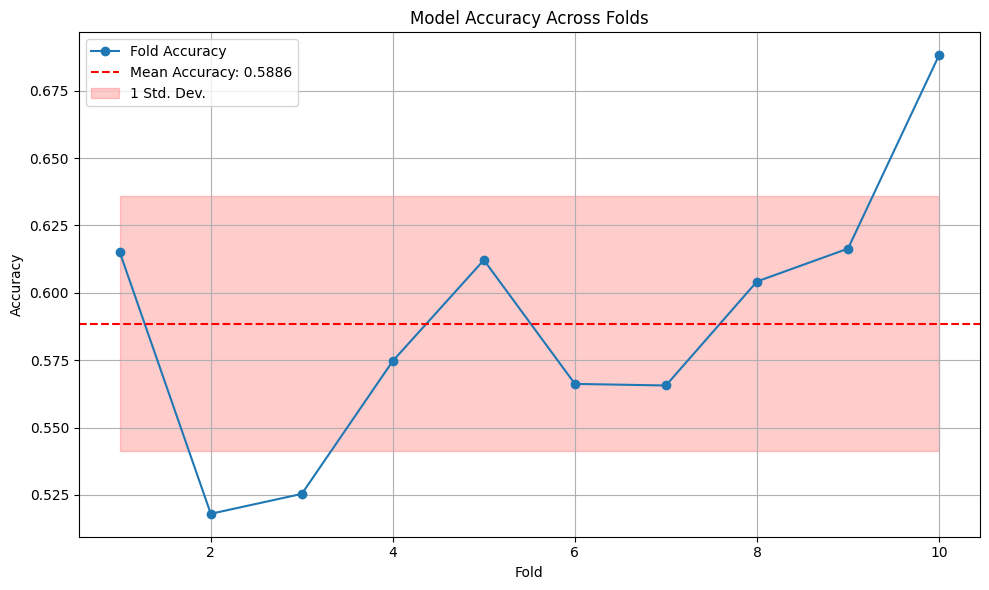

In [75]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), accuracies, marker='o', label='Fold Accuracy')
plt.axhline(np.mean(accuracies), color='r', linestyle='--', label=f'Mean Accuracy: {np.mean(accuracies):.4f}')
plt.fill_between(range(1, 11),
                 np.mean(accuracies) - np.std(accuracies),
                 np.mean(accuracies) + np.std(accuracies),
                 color='r', alpha=0.2, label='1 Std. Dev.')
plt.title("Model Accuracy Across Folds")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

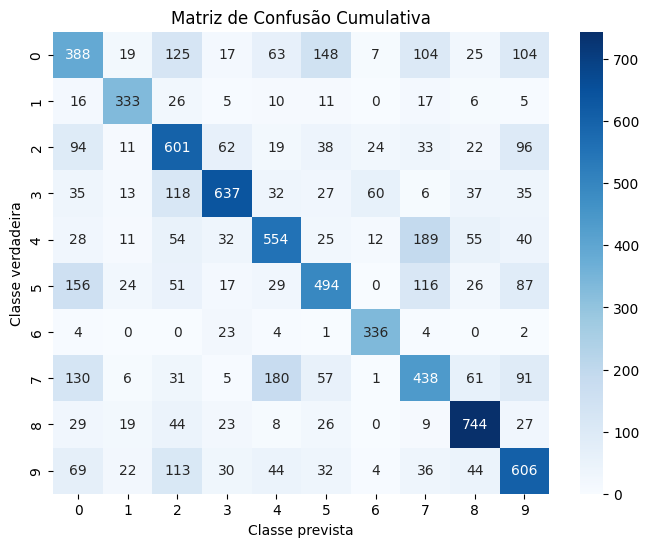

In [76]:
# Criar a matriz de confusão cumulativa após as 10 iterações
cumulative_conf_matrix = confusion_matrix(all_y_true, all_y_pred)

# Plotar a matriz de confusão cumulativa
plt.figure(figsize=(8, 6))
sns.heatmap(cumulative_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão Cumulativa')
plt.xlabel('Classe prevista')
plt.ylabel('Classe verdadeira')
plt.show()